In [1]:
#Data Preparation

In [2]:
import pandas as pd
#load osm data for KC
kc_osm_data = pd.read_csv('../../data/data_ohsome/new_kc_osm.csv')
#Melt the dataframe
value_vars = ['properties.amenity', 'properties.healthcare', 'properties.office', 'properties.historic', 'properties.natural', 
              'properties.shop', 'properties.tourism', 'properties.leisure', 'properties.sport', 'properties.aeroway', 'properties.man_made', 
              'properties.waterway']
id_vars = [x for x in kc_osm_data.columns if x not in value_vars]
kc_osm_data2 = pd.melt(kc_osm_data, 
                       id_vars=id_vars, 
                       value_vars=value_vars, 
                       var_name= 'key',
                       value_name= 'value')
#remove none values from tags
kc_osm_data2 = kc_osm_data2.dropna(subset=['value']) 
#select certain columns
kc_osm_data2 = kc_osm_data2[["geometry.coordinates", "properties.@osmId", "key", "value"]]
#convert to geopandas dataframe
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
kc_osm_data2['geometry.coordinates'] = kc_osm_data2['geometry.coordinates'].apply(lambda x: Point(eval(x)))
#plot the data
kc_osm_data2 = gpd.GeoDataFrame(kc_osm_data2, geometry = 'geometry.coordinates', crs="EPSG:27700")


C:\Users\smn18\AppData\Local\Temp\ipykernel_18948\3348689192.py:3: DtypeWarning: Columns (8,11,24,31,46,53,62,67,68,77,79,81,82,83,84,85,86,87,89,91,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,122,123,124,125,126,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,144,145,146,148,149,150,151,152,153,154,155,156,157,158,159,160,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,259,260,261,262,263,265,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,293,294,295,296,297,298,299,300,301,303,304,305,307,309,310,311,312,314,316,317,318,319,320,321,32

In [ ]:
#Run spatial clustering using DBSCAN

In [3]:
#Prepare dataset
from shapely.geometry import MultiPoint
#remove unnecessary values 
kc_osm_data2 = kc_osm_data2[~(kc_osm_data2.value.isin(["yes"]))]
kc_osm_data2['lon'] = kc_osm_data2['geometry.coordinates'].x
kc_osm_data2['lat'] = kc_osm_data2['geometry.coordinates'].y
kc_coords = kc_osm_data2[['lon', 'lat']].to_numpy()

C:\Users\smn18\AppData\Roaming\Python\Python311\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


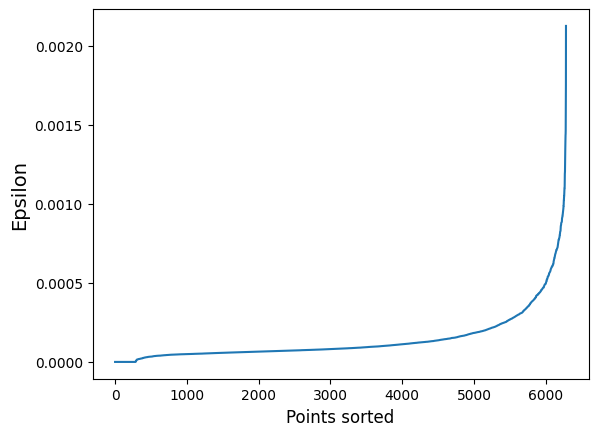

In [4]:
#finding the optimum epsilon
#Codes inspired from https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(kc_coords)
#distance between each point and its k nearest neighbour
distances, indices = neighbors_fit.kneighbors(kc_coords)
#sort distances in ascending order
distances = np.sort(distances, axis=0)
distances = distances[:,1]
#plot distances
plt.xlabel('Points sorted', fontsize=12)
plt.ylabel('Epsilon',fontsize=14)
plt.plot(distances)


no. of clusters: 118
no of noise: 474


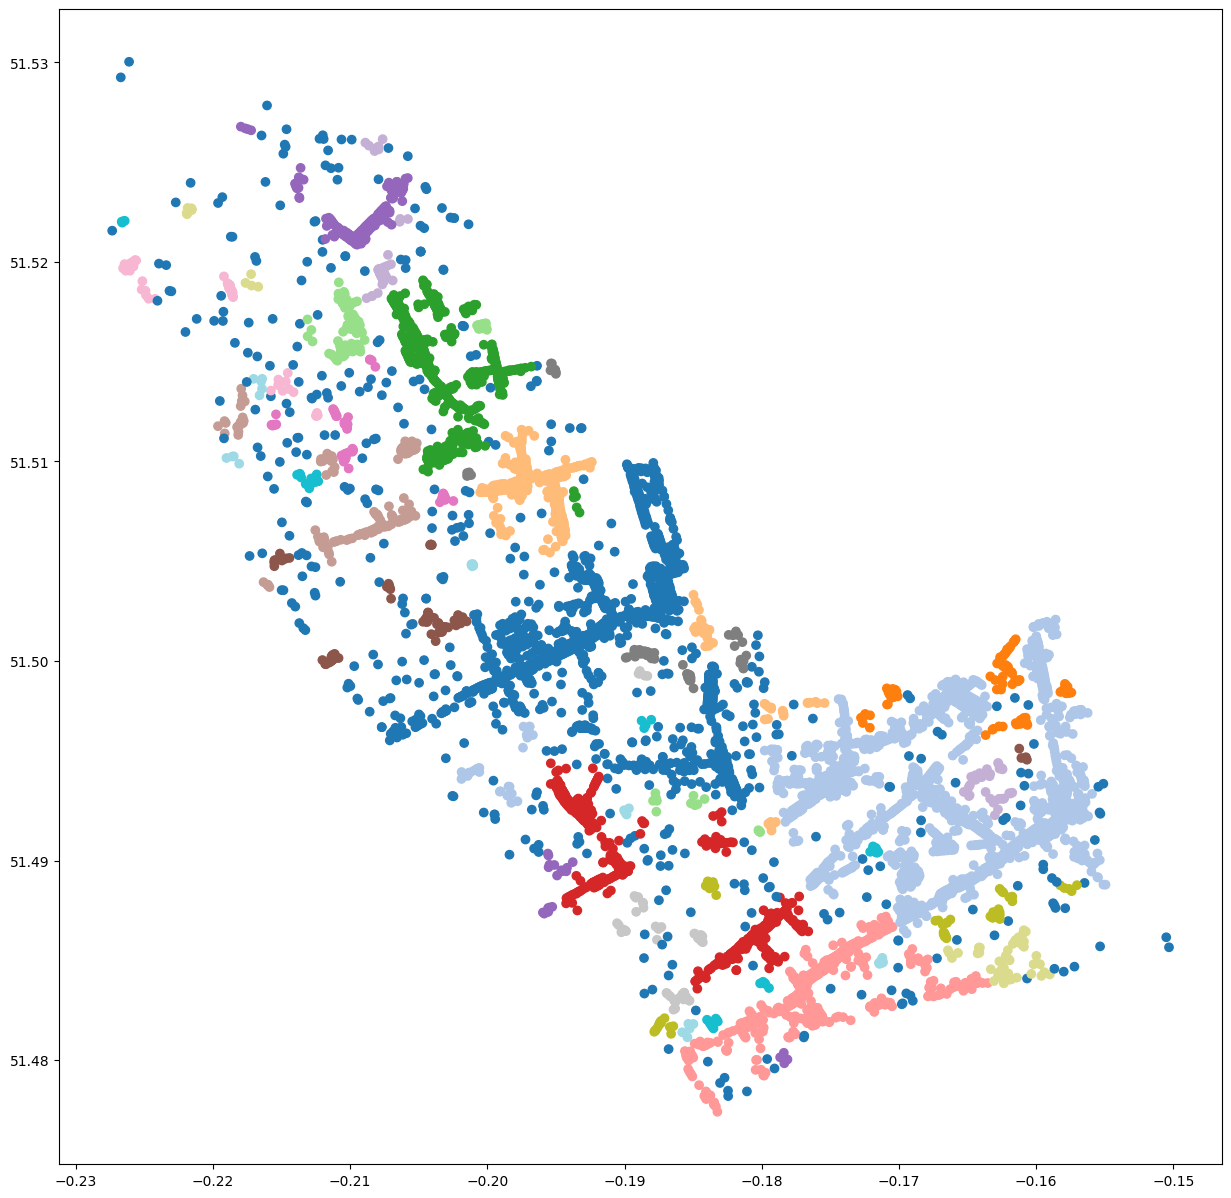

In [5]:
#run dbscan
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#run dbscan clustering
dbscan = DBSCAN(eps=0.0006, min_samples=4) #optimum epsilon 60m 
kc_dbscan = dbscan.fit(kc_coords)
#get the labels of clustering
dbscan_labels = kc_dbscan.labels_
dbscan_labels
print('no. of clusters:', len(np.unique(dbscan_labels)))
print('no of noise:', np.sum(np.array(dbscan_labels) == -1, axis=0))
#add cluster labels to dataset
kc_osm_data2['cluster'] = dbscan_labels
import matplotlib.pyplot as plt
#plot dbscan
plt.figure(figsize=(15, 15))
plt.scatter(kc_osm_data2['lon'], 
            kc_osm_data2['lat'], 
            c=kc_osm_data2['cluster'],
            cmap='tab20')
#plt.savefig('../../docs/docs_ohsome/dbscan_osm_kc.png')

plt.show()

In [ ]:
#Create polygons from DBBSCAN

In [6]:
#remove noise
remove = kc_osm_data2[kc_osm_data2['cluster'] == -1].index
kc_osm_data2 = kc_osm_data2.drop(remove)

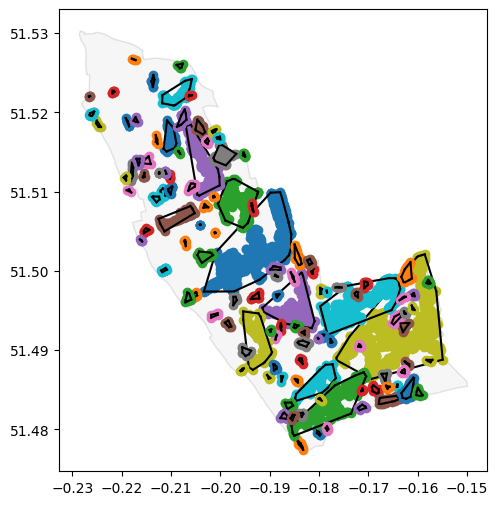

In [7]:
#Regionalise
#create convex hull
#Reference https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
import scipy
import numpy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt

#select only necessary column
db_cl = kc_osm_data2[["lon",
                   "lat",
                   "cluster"]]
import geopandas as gpd
#load boundary file for kc
kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
kc_boundary.to_crs(epsg=4326).plot(ax=ax,
                                  color= 'lightgrey', alpha= 0.2,
                                  edgecolor = '0.5')
#run convexhull for each clusters seperately
#create a list of convex hull
h = [] #for list of polygon coordinates from chull
for i in range(0,117):
    cluster_i = db_cl.loc[db_cl['cluster']==i]
    db_cl_i = cluster_i[["lon", "lat"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    h.append(db_cl_i[ch_i.vertices,:].tolist())
    plt.plot(db_cl_i[:, 0],db_cl_i[:, 1],  'o') #plot the points
    for simplex in ch_i.simplices:
        ploted=plt.plot(db_cl_i[simplex, 0], db_cl_i[simplex, 1],'k-') #plot the simplices (indices of points that forms the facets of the convexhull)

#Ref: https://stackoverflow.com/questions/61740032/how-to-convert-convex-hull-vertices-into-a-geopandas-polygon
from shapely.geometry import MultiPoint
c_h = []
for hull in h:
    c_h.append(MultiPoint(hull).convex_hull)


In [ ]:
#Create ordered-sequence of POIs for input into LDA

In [8]:
#create a function for centroid calculation
import scipy
import numpy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from shapely.geometry import Polygon
#select only necessary column
db_cl = kc_osm_data2[["lon",
                   "lat",
                   "cluster",
                    "value"]]
def centroid_calc (in_df):
    db_cl_i = in_df[["lon", "lat"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    hull_indices = ch_i.vertices
    hull_pts = db_cl_i[hull_indices, :]
    #find the centroid of polygon
    p_i = Polygon(hull_pts)
    centroid_i = p_i.centroid      
    return centroid_i
        
cluster_centroid = pd.DataFrame(kc_osm_data2.groupby(['cluster']).apply(centroid_calc))
cluster_centroid.rename(columns = {0:'poly_centroid'}, inplace = True)
cluster_centroid['lon'] = cluster_centroid.poly_centroid.apply(lambda p: p.x)
cluster_centroid['lat'] = cluster_centroid.poly_centroid.apply(lambda p: p.y)

C:\Users\smn18\AppData\Local\Temp\ipykernel_18948\3450336635.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_centroid = pd.DataFrame(kc_osm_data2.groupby(['cluster']).apply(centroid_calc))


In [9]:
#join the clustered centroid data
kc_osm_with_centroid = pd.merge(kc_osm_data2, cluster_centroid, on=['cluster'])

In [10]:
#calculate distance from point to centroid and sort by shortest distance
import geopy
from geopy.distance import geodesic
def distance_calc(row):
    coords_1 = (row['lat_x'], row['lon_x'])
    coords_2 = (row['lat_y'], row['lon_y'])
    return geodesic(coords_1, coords_2).km
kc_osm_with_centroid['distance'] = kc_osm_with_centroid.apply(distance_calc, axis=1)
kc_osm_with_centroid = kc_osm_with_centroid.sort_values(by=['cluster', 'distance'], ascending = [True, True])

In [11]:
#get tag list for each dbscan cluster as a list
osm_kc_dbscan = kc_osm_with_centroid.groupby('cluster')['value'].apply(list)
data_dbscan = pd.DataFrame(osm_kc_dbscan)
tag_list_dbscan = data_dbscan.value.values.tolist()
data_dbscan

,value
cluster,
0,"[clothes, fireplace, florist, jewelry, hairdre..."
1,"[supermarket, atm, telephone, convenience, pos..."
2,"[car_sharing, tree, tree, cafe, tree, car, tre..."
3,"[cafe, dry_cleaning, greengrocer, dry_cleaning..."
4,"[memorial, bicycle_rental, apartment, motorcyc..."
...,...
112,"[tree, tree, tree, hostel, tree]"
113,"[tree, tree, tree, tree, tree, tree, tree, tree]"
114,"[tree, tree, tree, car_wash, tree]"


In [ ]:
#Start LDA topic modeling

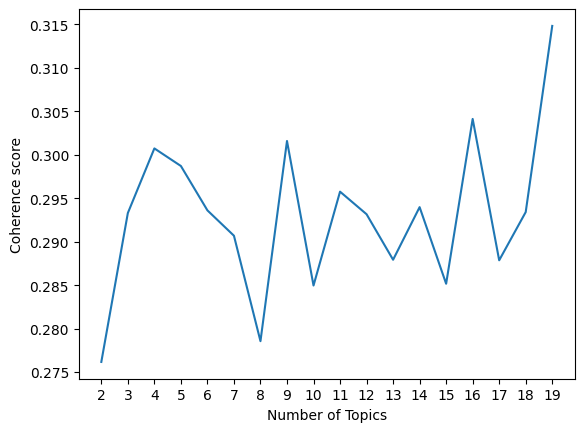

In [12]:
#calculate coherence value for differenct topic number
#Code inspired from https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920
#gensim reference: https://radimrehurek.com/gensim/models/coherencemodel.html
#https://radimrehurek.com/gensim/models/ldamodel.html
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
# Create a corpus from a list of texts
dictionary = Dictionary(tag_list_dbscan)
corpus = [dictionary.doc2bow(text) for text in tag_list_dbscan]
coherence_values = []
def coherence_value(dictionary, texts, corpus, start, stop, step):
    for num_topics in range(start, stop, step):
        lda_model = LdaModel(corpus=corpus,
                              num_topics=num_topics)
        coherencemodel = CoherenceModel(model=lda_model,
                                        corpus=corpus,
                                        dictionary=dictionary,
                                        texts = texts,
                                        coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)

    return coherence_values

#run the function to find optimum number of topics
coherence_values = coherence_value(dictionary=dictionary, 
                                   corpus=corpus, 
                                   texts = tag_list_dbscan,
                                   start=2, 
                                   stop=20, 
                                   step=1)

#plot as graph
x = range(2, 20)
plt.plot(x, coherence_values)
plt.xticks(range(2,20))
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.show()
    

In [13]:
#build lda with optimum topic number
lda_model_osm = LdaModel(corpus=corpus, 
                      num_topics=9,
                      id2word = dictionary)
                      #per_word_topics=True)
#print the topics
#lda_model.print_topics()
lda_model_osm.show_topics(num_words = 20)

[(0,
  '0.220*"tree" + 0.082*"clothes" + 0.059*"bench" + 0.057*"bicycle_parking" + 0.049*"restaurant" + 0.022*"memorial" + 0.022*"cafe" + 0.020*"estate_agent" + 0.020*"post_box" + 0.019*"hairdresser" + 0.019*"antiques" + 0.018*"beauty" + 0.016*"vacant" + 0.014*"motorcycle_parking" + 0.014*"telephone" + 0.011*"pharmacy" + 0.011*"dry_cleaning" + 0.011*"dentist" + 0.010*"bicycle_rental" + 0.009*"fast_food"'),
 (1,
  '0.297*"tree" + 0.056*"cafe" + 0.030*"pharmacy" + 0.028*"bicycle_parking" + 0.026*"restaurant" + 0.023*"motorcycle_parking" + 0.021*"fast_food" + 0.018*"charity" + 0.017*"post_box" + 0.017*"clothes" + 0.015*"estate_agent" + 0.014*"vacant" + 0.013*"convenience" + 0.013*"car" + 0.012*"bench" + 0.011*"memorial" + 0.011*"beauty" + 0.010*"car_sharing" + 0.010*"bicycle_rental" + 0.008*"books"'),
 (2,
  '0.066*"restaurant" + 0.055*"bicycle_parking" + 0.051*"beauty" + 0.050*"post_box" + 0.049*"bench" + 0.039*"tree" + 0.038*"clothes" + 0.036*"memorial" + 0.031*"hairdresser" + 0.028*"ca

In [ ]:
#visualise 
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
fig=plt.figure(figsize=(15,30))
fig_no = 0
for i in range(0,9):
    df=pd.DataFrame(lda_model_osm.show_topic(i, topn = 20), 
                    columns=['term','probability']).set_index('term')
    plt.subplot(5,2,i+1)
    plt.title('Topic '+str(i+1))
    sns.barplot(x='probability',
                y=df.index, 
                data=df, 
                palette='Reds_d')
    plt.xlabel('probability')
    fig_no += 1
    

plt.show()

In [29]:
#Compute Perplexity
perplexity_lda = lda_model_osm.log_perplexity(corpus)
print('\nPerplexity: ', perplexity_lda )  # a measure of how good the model is lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_osm, 
                                     texts=tag_list_dbscan, 
                                     dictionary=dictionary, 
                                     coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.238200093374947

Coherence Score:  -0.9309835144013834


In [30]:
#Topic distribution for each dbscan cluster
all_topics = lda_model_osm.get_document_topics(corpus)
num_docs = len(all_topics)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
colnames = ['Topic'+str(i+1) for i in range(0,9)]
all_topics_df = pd.DataFrame(all_topics_numpy, columns = colnames)
#find the dominant topic for each DBSCAN cluster
all_topics_df['Topic'] = all_topics_df[colnames].idxmax(axis=1)
all_topics_df

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic
0,0.000000,0.000000,0.000000,0.000000,0.881177,0.000000,0.117300,0.000000,0.000000,Topic5
1,0.000000,0.000000,0.000000,0.000000,0.936471,0.000000,0.000000,0.000000,0.000000,Topic5
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.950592,0.000000,0.000000,Topic7
3,0.000000,0.000000,0.964426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Topic3
4,0.000000,0.000000,0.000000,0.000000,0.229387,0.716422,0.000000,0.047987,0.000000,Topic6
...,...,...,...,...,...,...,...,...,...,...
112,0.018524,0.018519,0.018524,0.018523,0.018529,0.018524,0.851810,0.018521,0.018526,Topic7
113,0.012350,0.012346,0.012349,0.012349,0.012354,0.012349,0.901203,0.012348,0.012351,Topic7
114,0.018524,0.018519,0.018526,0.018523,0.018529,0.018523,0.851808,0.018521,0.018526,Topic7
115,0.018522,0.350188,0.018525,0.520141,0.018526,0.018525,0.018525,0.018526,0.018522,Topic4


In [31]:
##add c_h polygon coordinates
all_topics_df['geometry'] = c_h
#set index as column
all_topics_df['cluster'] = all_topics_df.index

In [33]:
#add topic labels
#Name the lda topics
def get_osm_topic_name(topic):
    if topic == 'Topic1':
        return 'High street shops'
    elif topic == 'Topic2':
        return 'Park & Green spaces'
    elif topic == 'Topic3':
        return 'Embassy and High Commission '
    elif topic == 'Topic4':
        return 'Gallery & Memorial'
    elif topic == 'Topic5':
        return 'Gallery & Memorial'
    elif topic == 'Topic6':
        return 'Restaurant, cafe and food shops'
    else:
        return 'Park & Green spaces'
all_topics_df['LDA_Topic_OSM'] = all_topics_df['Topic'].apply(get_osm_topic_name)

In [ ]:
#Spatial Distribution of LDA topics

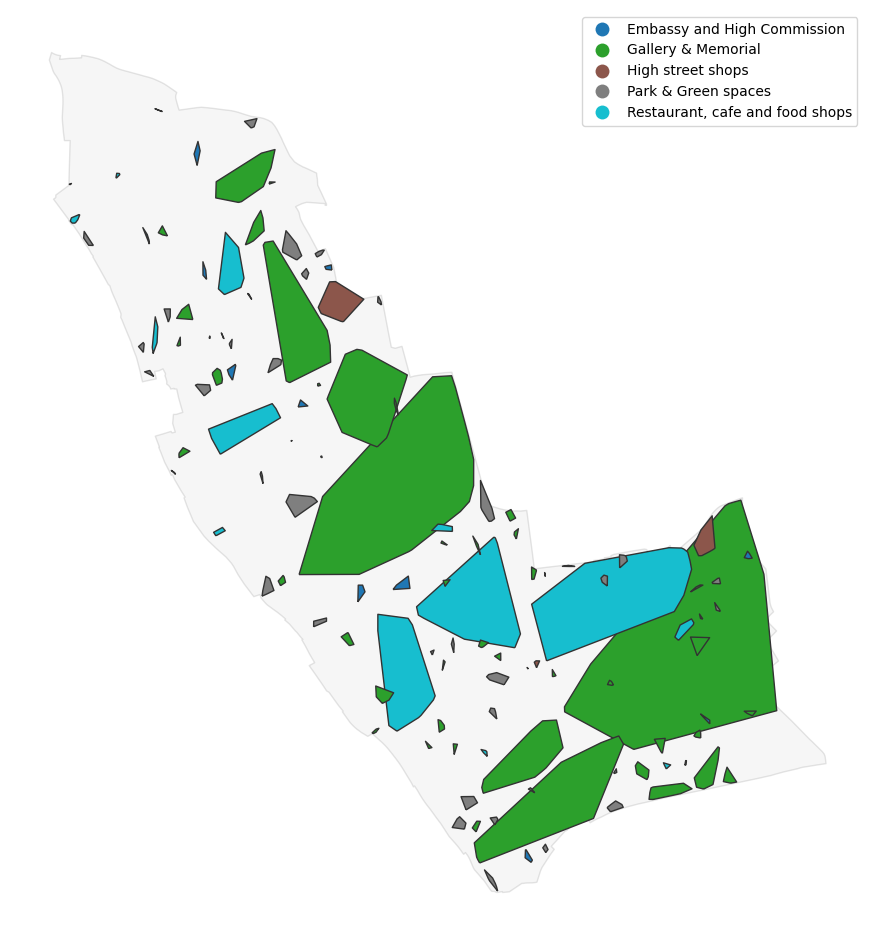

In [39]:
all_topics_gdf_osm = gpd.GeoDataFrame(all_topics_df, geometry="geometry", crs='EPSG:4326')
#load boundary file for kc
kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(20, 12))
kc_boundary.to_crs(epsg=4326).plot(ax=ax,
                                  color= 'lightgrey', alpha= 0.2,
                                  edgecolor = '0.5')
all_topics_gdf_osm.plot(column='LDA_Topic_OSM', 
                      categorical = True  , 
                      edgecolor='0.2',
                      cmap='tab10', 
                      ax=ax, 
                      legend = True
                      
                     )
ax.set_axis_off()
